In [ ]:
# citations of orignals:
# """
# first two attempts were DCGANs (result were mode collapse)
# MNIST DCGAN by TensorFlow Authors: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb#scrollTo=ZBwyU6t2Wf3g
# Monet_ Dataset DCGAN architecture: https://www.kaggle.com/code/thuylinh225/generate-monet-images-using-dcgan
# naming convention for models: https://github.com/thashimoto1998/DCGAN/blob/master/dcgan.py
#
# third attempt is WGAN-GP (better results)
# WGAN-GP video: https://www.youtube.com/watch?v=pG0QZ7OddX4&list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va&index=5
# WGAN-GP paper: https://arxiv.org/abs/1704.00028
# WGAN-GP github: https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/4.%20WGAN-GP
# """

In [ ]:
###############################
###         Updates         ###
###############################

#removed text cells
# added WGAN-GP
# added outputs folder to save GIFs

In [11]:
import tensorflow as tf
import glob
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import imageio

!pip install tensorflow_docs
import tensorflow_docs.vis.embed as embed
import torchvision.transforms as transforms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 1.7 MB/s eta 0:00:00


In [12]:
#Gather images
!git clone https://github.com/LyJacky/ImageGeneration.git

Cloning into 'ImageGeneration'...
remote: Enumerating objects: 375, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 375 (delta 27), reused 69 (delta 26), pack-reused 305
Receiving objects: 100% (375/375), 49.93 MiB | 19.16 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [ ]:
# import torchvision

In [ ]:
# hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
BATCH_SIZE = 32
IMAGE_SIZE = 64
CHANNELS_IMG = 3
LAMBDA_GP = 10

Z_DIM = 100
FEATURES_GENERATOR = 64

LEARNING_RATE = 1e-4
FEATURES_DISCRIMINATOR = 64
DISCRIMINATOR_ITERATIONS = 5

transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(IMAGE_SIZE), # to 64
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

cpu


In [ ]:
!ls -a

.  ..  .config	ImageGeneration  outputs  sample_data


In [ ]:
!rm -r /content/ImageGeneration/ImageGeneration/
!rm -r /content/ImageGeneration/.ipynb_checkpoints/
!rm -r /content/ImageGeneration/.git/

rm: cannot remove '/content/ImageGeneration/ImageGeneration/': No such file or directory
rm: cannot remove '/content/ImageGeneration/.ipynb_checkpoints/': No such file or directory
rm: cannot remove '/content/ImageGeneration/.git/': No such file or directory


In [ ]:
# if this error:
# FileNotFoundError: Found no valid file [...] extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp
# then: make sure to not have image_at_epoch_0010.jpg in the folder

monet_dataset = datasets.ImageFolder(root="/content/ImageGeneration/", transform=transforms)
dataloader = DataLoader(monet_dataset, batch_size=BATCH_SIZE, shuffle=True)

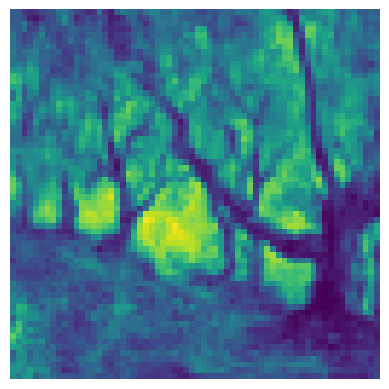

In [ ]:
# show a sample
plt.imshow((monet_dataset[1][0][2]))
plt.axis('off')
plt.show()

In [ ]:
#############################
###    WGAN-GP Original    ###
#############################

In [ ]:
def gradient_penalty(discriminator, real, fake, device="cpu"):
  BATCH_SIZE, C, H, W = real.shape
  epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
  interpolated_images = real * epsilon + fake * (1 - epsilon)

  # calcuate discriminator scores
  mixed_scores = discriminator(interpolated_images)

  gradient = torch.autograd.grad(
      inputs = interpolated_images,
      outputs = mixed_scores,
      grad_outputs = torch.ones_like(mixed_scores),
      create_graph = True,
      retain_graph = True,
  )[0]

  gradient = gradient.view(gradient.shape[0], -1)
  gradient_penalty = torch.mean((gradient - 1) ** 2)
  return gradient_penalty


In [ ]:
class Discriminator(nn.Module):
  def __init__(self, channels_img, features_d):
    super(Discriminator, self).__init__()
    self.discriminator = nn.Sequential(

        # Input Layer
        nn.Conv2d(channels_img, features_d, kernel_size = 4, stride = 2, padding = 1),
        nn.LeakyReLU(0.2),

        # Second Layer
        nn.Sequential(
          nn.Conv2d(features_d, features_d * 2, kernel_size=4, stride=2, padding=1, bias=False,),
          nn.InstanceNorm2d(features_d * 2, affine=True),
          nn.LeakyReLU(0.2),
        ),

        # Third Layer
        nn.Sequential(
          nn.Conv2d(features_d * 2, features_d * 4, kernel_size=4, stride=2, padding=1, bias=False,),
          nn.InstanceNorm2d(features_d * 4, affine=True),
          nn.LeakyReLU(0.2),
        ),

        # Fourth Layer
        nn.Sequential(
          nn.Conv2d(features_d * 4, features_d * 8, kernel_size=4, stride=2, padding=1, bias=False,),
          nn.InstanceNorm2d(features_d * 8, affine=True),
          nn.LeakyReLU(0.2),
        ),

        # Output Layer is 4x4 (Conv2d turns into 1x1)
        nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0)
    )


  def forward(self, x):
    return self.discriminator(x)

In [ ]:
class Generator(nn.Module):
  def __init__(self, channels_noise, channels_img, features_g):
    super(Generator, self).__init__()
    self.generator = nn.Sequential(

        #  Input Layer
        nn.Sequential(
          nn.ConvTranspose2d(channels_noise, features_g * 16, kernel_size=4, stride=1, padding=0, bias=False,),
          nn.BatchNorm2d(features_g * 16),
          nn.ReLU(),
        ),

        #  Second Layer
        nn.Sequential(
          nn.ConvTranspose2d(features_g * 16, features_g * 8, kernel_size=4, stride=2, padding=1, bias=False,),
          nn.BatchNorm2d(features_g * 8),
          nn.ReLU(),
        ),

        #  Third Layer
        nn.Sequential(
          nn.ConvTranspose2d(features_g * 8, features_g * 4, kernel_size=4, stride=2, padding=1, bias=False,),
          nn.BatchNorm2d(features_g * 4),
          nn.ReLU(),
        ),

        #  Fourth Layer
        nn.Sequential(
          nn.ConvTranspose2d(features_g * 4, features_g * 2, kernel_size=4, stride=2, padding=1, bias=False,),
          nn.BatchNorm2d(features_g * 2),
          nn.ReLU(),
        ),

        #  Output Layer
        nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
        nn.Tanh(),
    )

  def forward(self, x):
    return self.generator(x)

In [ ]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
def save_checkpoints(state, filename="monet_wgan_gp.pth.tar"):
  print("=> Saving checkpoint")
  os.mkdir('/content/checkpoints/')
  os.chdir('/content/checkpoints/')
  torch.save(state, filename)

def load_checpoint(checkpoint, generator, discriminator):
  print("=> Loading checkpoint")
  os.chdir('/content/checkpoints/')
  generator.load_state_dict(checkpoint['generator'])   # generator
  discriminator.load_state_dict(checkpoint['discriminator']) # discriminator

In [ ]:
def wgan_generate_images():
    noise = tf.random.normal([BATCH_SIZE, Z_DIM])
    # predictions = generator.predict(noise)
    fake = generator(noise)
    return fake

def wgan_generate_and_plot_images():
    image = wgan_generate_images()
    generator_imgs = 0.5 * image + 0.5
    fig = plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(generator_imgs[i, :, :, :])
        plt.axis('off')
    plt.show()

In [ ]:
generator = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GENERATOR).to(device)
discriminator = Discriminator(CHANNELS_IMG, FEATURES_DISCRIMINATOR).to(device)
initialize_weights(generator)
initialize_weights(discriminator)

opt_generator = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_discriminator = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
step = 0

In [ ]:
generator.train()

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(12

In [ ]:
discriminator.train()

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [ ]:
EPOCHS = 5

In [ ]:
!PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
!mkdir /content/outputs
!mkdir /content/outputs/first_wgan

mkdir: cannot create directory ‘/content/outputs’: File exists
mkdir: cannot create directory ‘/content/outputs/first_wgan’: File exists


In [ ]:
noise_dim = 100
num_examples_to_generate = 5

# We will reuse this seed overtime to visualize progress in a GIF
seed = torch.randn(num_examples_to_generate, noise_dim, 1, 1).to(device)

EPOCH [0/5] Batch 0/10 Loss D: -24.3297, loss G: 31.9612


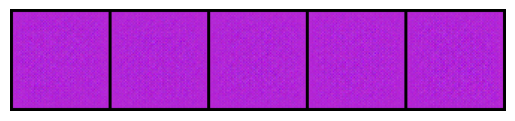

In [ ]:
#training

for epoch in range(EPOCHS):
  for batch_idx, (real_img, _) in enumerate(dataloader):
    real = real_img.to(device)
    if len(real) < 32: # sometimes had tensor of size 12
        break

    for _ in range(DISCRIMINATOR_ITERATIONS):
      noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
      fake = generator(noise)
      discriminator_real = discriminator(real).reshape(-1)
      discriminator_fake = discriminator(fake).reshape(-1)
      gp = gradient_penalty(discriminator, real, fake, device=device)
      loss_discriminator = (
          -(torch.mean(discriminator_real) - torch.mean(discriminator_fake)) + LAMBDA_GP*gp
      )
      discriminator.zero_grad()
      loss_discriminator.backward(retain_graph=True)
      opt_discriminator.step()

    output = discriminator(fake).reshape(-1)
    loss_generator = -torch.mean(output)
    generator.zero_grad()
    loss_generator.backward()
    opt_generator.step()

    #generate pics with random noise
    with torch.no_grad():
        img_grid_fake = torchvision.utils.make_grid(
          fake[:5], normalize=True
        )
        plt.imshow(img_grid_fake.cpu().detach().numpy().transpose(1, 2, 0))
        plt.axis('off')
        if epoch % 5 == 0 and batch_idx == 0:
          print(
              f"EPOCH [{epoch}/{EPOCHS}] Batch {batch_idx}/{len(dataloader)} Loss D: {loss_discriminator:.4f}, loss G: {loss_generator:.4f}"
          )
          plt.show()

    # generate with consistent seed/noise and save .png
    with torch.no_grad():
        if epoch % 2 == 0 and batch_idx == 0:
          fake = generator(seed)
          img_grid_fake = torchvision.utils.make_grid(
            fake[:], normalize=True
          )
          plt.imshow(img_grid_fake.cpu().detach().numpy().transpose(1, 2, 0))
          plt.axis('off')
          plt.savefig('/content/outputs/first_wgan/image_at_epoch_{:04d}.png'.format(epoch + 1))

    step += 1

In [ ]:
anim_file = 'wgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/outputs/first_wgan/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [1]:
#############################
###    WGAN-GP Attempt    ###
#############################

In [2]:
"""
dataset = datasets.

- change cpu in gradient_penalty?
- different learning rates for disc, gen
- keep image size
DISC_ITERATIONS = 10
- padding = 2 # used to be 1
- kernel size = 5

FEATURES_DISC = 64?
FEATURES_GEN = 64?

init weights

Constrain Critic Weights:
After each mini-batch update, limit the critic model weights to a specific range (e.g., [-0.01, 0.01]).
This constraint prevents the critic from becoming too dominant and ensures stability during training.
"""

'\ndataset = datasets.\n\n- change cpu in gradient_penalty?\n- different learning rates for disc, gen\n- keep image size\nDISC_ITERATIONS = 10\n- padding = 2 # used to be 1\n- kernel size = 5\n\nFEATURES_DISC = 64?\nFEATURES_GEN = 64?\n\ninit weights\n\nConstrain Critic Weights:\nAfter each mini-batch update, limit the critic model weights to a specific range (e.g., [-0.01, 0.01]).\nThis constraint prevents the critic from becoming too dominant and ensures stability during training.\n'

In [13]:
def gradient_penalty(disc, real, fake, device="cpu"):
  BATCH_SIZE, C, H, W = real.shape
  epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
  interpolated_images = real * epsilon + fake * (1 - epsilon)

  # calcuate discriminator scores
  mixed_scores = disc(interpolated_images)

  gradient = torch.autograd.grad(
      inputs = interpolated_images,
      outputs = mixed_scores,
      grad_outputs = torch.ones_like(mixed_scores),
      create_graph = True,
      retain_graph = True,
  )[0]

  gradient = gradient.view(gradient.shape[0], -1)
  gradient_norm = gradient.norm(2, dim=1)
  gradient_penalty = torch.mean((gradient - 1) ** 2)
  return gradient_penalty


In [14]:
class Discriminator(nn.Module):
  def __init__(self, channels_img, features_d):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        #                    3,         64,
        nn.Conv2d(channels_img, features_d, kernel_size = 4, stride = 2, padding = 1),
        nn.LeakyReLU(0.2),

        #_block(in_channels, out_channels, kernel_size, stride, padding)
        #                   64,            128,
        self._block(features_d, features_d * 2, 4, 2, 1),
        #                   64,            128,
        self._block(features_d * 2, features_d * 4, 4, 2, 1),
        #                   256,            512,
        self._block(features_d * 4, features_d * 8, 4, 2, 1),

        # output is 4x4 (Conv2d turns into 1x1)
        #                    512,
        nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0)
    )
  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        # nn.BatchNorm2d(out_channels),
        nn.InstanceNorm2d(out_channels, affine=True),
        nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    return self.disc(x)

In [15]:
class Generator(nn.Module):
  def __init__(self, channels_noise, channels_img, features_g):
    super(Generator, self).__init__()
    self.net = nn.Sequential(
        self._block(channels_noise, features_g * 16, 4, 1, 0),
        self._block(features_g * 16, features_g * 8, 4, 2, 1),
        self._block(features_g * 8, features_g * 4, 4, 2, 1),
        self._block(features_g * 4, features_g * 2, 4, 2, 1),
        nn.ConvTranspose2d(
            features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
        ),
        nn.Tanh(),
    )
  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

  def forward(self, x):
    return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"


In [16]:
import torchvision.transforms as transforms

In [17]:
# hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# LEARNING_RATE = 1e-4
DISCRIMINATOR_LEARNING_RATE = 1e-4
GENERATOR_LEARNING_RATE = 5e-5
BATCH_SIZE = 32
CHANNELS_IMG = 3
Z_DIM = 100
IMAGE_SIZE = 64
FEATURES_DISC = 64
FEATURES_GEN = 64
DISC_ITERATIONS = 5 # used to be 5
LAMBDA_GP = 10 # Loss weight for gradient penalty

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

cpu


In [18]:
# checkpoints

def save_checkpoints(state, filename="monet_wgan_gp.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state, filename)

def load_checpoint(checkpoint, gen, disc):
  print("=> Loading checkpoint")
  gen.load_state_dict(checkpoint['gen'])   # generator
  disc.load_state_dict(checkpoint['disc']) # discriminator

In [19]:
def wgan_generate_images():
    noise = tf.random.normal([BATCH_SIZE, Z_DIM])
    # predictions = gen.predict(noise)
    fake = gen(noise)
    return fake

def wgan_generate_and_plot_images():
    image = wgan_generate_images()
    gen_imgs = 0.5 * image + 0.5
    fig = plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(gen_imgs[i, :, :, :])
        plt.axis('off')
    plt.show()

In [20]:
!rm -r ../ImageGeneration/
!rm -r ../.ipynb_checkpoints/
!rm -r ../.git/

rm: cannot remove '../ImageGeneration/': No such file or directory
rm: cannot remove '../.ipynb_checkpoints/': No such file or directory
rm: cannot remove '../.git/': No such file or directory


In [23]:
# make sure to not have image_at_epoch_0010.jpg in the folder

# dataset = datasets.ImageFolder(root="/content/ImageGeneration/", transform=transforms)
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=GENERATOR_LEARNING_RATE, betas=(0.0, 0.9))
opt_disc = optim.Adam(disc.parameters(), lr=DISCRIMINATOR_LEARNING_RATE, betas=(0.0, 0.9))

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
# writer_real = SummaryWriter(f"logs/real")
# writer_fake = SummaryWriter(f"logs/fake")
step = 0

In [ ]:
# print(len(dataset))
# print(len(dataset[0]))
# print((dataset[0][0]), "\n")
# print((dataset[0][0][0]), "\n")
# print((dataset[0][0][0][0]), "\n")

In [ ]:
# # show some samples
# fig = plt.figure(figsize=(4, 4))

# for i in range(4):
#   sample = dataset[i][0].numpy()

#   sample = sample.transpose(1,2,0)

#   sample = (sample[:, :, :] * 127.5 + 127.5).astype(np.int8)


#   plt.subplot(2, 2, i+1)
#   plt.imshow(sample)
#   plt.axis('off')
# plt.show()

In [ ]:
# show some samples
plt.imshow((dataset[1][0][2]))
plt.axis('off')
plt.show()

In [24]:
gen.train()

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 3, 

In [25]:

disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [ ]:
EPOCHS = 150

In [ ]:
!PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
!mkdir ../../outputs
!mkdir ../../outputs/second_wgan

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)

 # keep seperate from training to not reset seed incase of running training cell > 1
seed = torch.randn(num_examples_to_generate, noise_dim, 1, 1).to(device)

In [ ]:
#training

for epoch in range(EPOCHS):
  for batch_idx, (real_img, _) in enumerate(dataloader):
    real = real_img.to(device)
    if len(real) < 32: # sometimes had tensor of size 12
        break

    for _ in range(DISC_ITERATIONS):
      #                           32,
      noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
      fake = gen(noise)
      disc_real = disc(real).reshape(-1)
      disc_fake = disc(fake).reshape(-1)
      gp = gradient_penalty(disc, real, fake, device=device)
      loss_disc = (
          -(torch.mean(disc_real) - torch.mean(disc_fake)) + LAMBDA_GP*gp
      )
      disc.zero_grad()
      loss_disc.backward(retain_graph=True)
      opt_disc.step()

    output = disc(fake).reshape(-1)
    loss_gen = -torch.mean(output)
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    #generate pics
    with torch.no_grad():
        # fake = gen(seed)
        img_grid_fake = torchvision.utils.make_grid(
          fake[:5], normalize=True
        )
        plt.imshow(img_grid_fake.cpu().detach().numpy().transpose(1, 2, 0))
        plt.axis('off')
        if epoch % 5 == 0 and batch_idx == 0:
          print(
              f"EPOCH [{epoch}/{EPOCHS}] Batch {batch_idx}/{len(dataloader)} Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
          )
          plt.show()

    # generate with seed and save GIF
    with torch.no_grad():
        if epoch % 2 == 0 and batch_idx == 0:
          fake = gen(seed)
          img_grid_fake = torchvision.utils.make_grid(
            fake[:5], normalize=True
          )
          plt.imshow(img_grid_fake.cpu().detach().numpy().transpose(1, 2, 0))
          plt.axis('off')
          plt.savefig('/content/outputs/second_wgan/image_at_epoch_{:04d}.png'.format(epoch + 1))

    step += 1

In [ ]:
anim_file = 'wgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('../../outputs/first_wgan/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)